Example turbine locations:
   TurbID          x           y
0       1  3349.8515  5939.23193
1       2  3351.0017  6416.64673
2       3  3314.7797  6892.18395
3       4  3352.0940  7366.14203
4       5  3355.3420  7841.20175
Edge indices (source -> target):
[[  0   0   1   1   2   2   3   4   4   5   5   6   6   7   7   8   8   9
    9  10  14  15  15  16  16  17  17  18  18  19  19  20  20  21  21  22
   22  23  23  24  24  24  25  25  25  26  26  26  27  27  27  28  28  28
   29  29  29  30  30  30  31  31  32  33  34  34  37  38  38  39  39  39
   40  40  40  41  41  41  42  42  42  43  43  43  44  44  44  45  45  45
   46  46  46  47  47  48  48  48  49  49  49  50  50  50  51  51  51  52
   52  53  55  56  56  58  59  59  60  60  60  61  61  61  62  62  62  63
   63  63  64  64  64  65  65  65  66  66  66  67  67  67  68  68  68  69
   69  69  70  70  70  71  71  71  72  72  72  73  73  73  74  74  74  75
   75  75  76  76  76  77  77  77  78  78  78  83  84  84  85  85  85  86
  

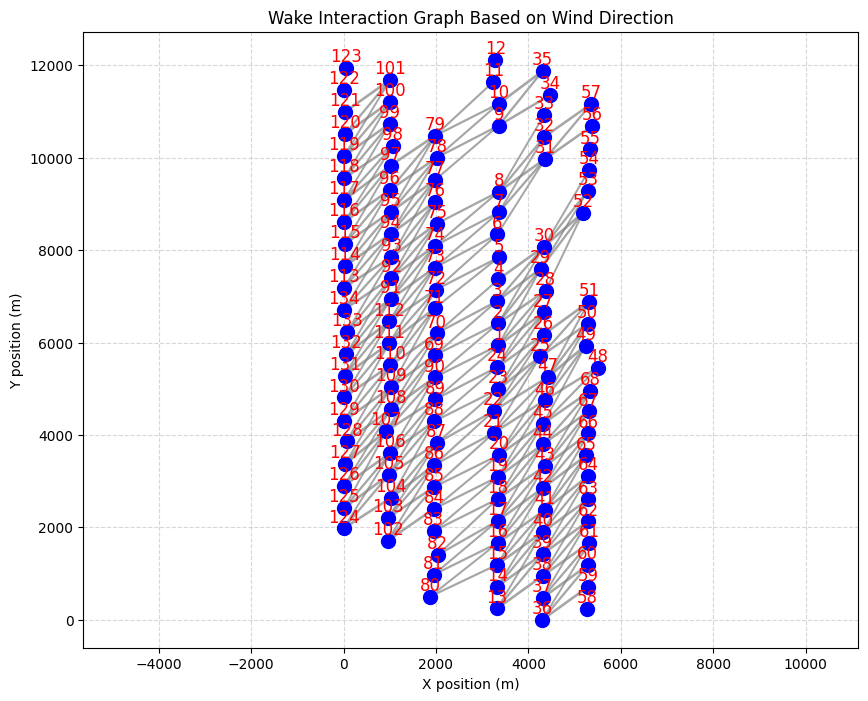

Edge from node 0 to node 88 with weight 0.166
Edge from node 0 to node 89 with weight 0.203
Edge from node 1 to node 68 with weight 0.202
Edge from node 1 to node 89 with weight 0.163
Edge from node 2 to node 68 with weight 0.168
Edge from node 2 to node 69 with weight 0.219
Edge from node 3 to node 69 with weight 0.169
Edge from node 4 to node 70 with weight 0.170
Edge from node 4 to node 71 with weight 0.208
Edge from node 5 to node 71 with weight 0.167
Edge from node 5 to node 72 with weight 0.207
Edge from node 6 to node 72 with weight 0.160
Edge from node 6 to node 73 with weight 0.200
Edge from node 7 to node 73 with weight 0.162
Edge from node 7 to node 74 with weight 0.210
Edge from node 8 to node 76 with weight 0.163
Edge from node 8 to node 77 with weight 0.211
Edge from node 9 to node 77 with weight 0.169
Edge from node 9 to node 78 with weight 0.202
Edge from node 10 to node 78 with weight 0.179
Edge from node 14 to node 79 with weight 0.188
Edge from node 15 to node 79 wit

In [1]:
# wind_power_forecasting/graph_construction.py

import torch
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
import numpy as np
import pandas as pd
from config import SPATIAL_GRAPH_TYPE, SPATIAL_RADIUS, K_NEIGHBORS, TEMPORAL_GRAPH_TYPE
from torch_geometric.utils import to_undirected, coalesce, remove_self_loops
import matplotlib.pyplot as plt

def compute_wake_edges(coords, wind_dir, decay_length=1000.0, angle_threshold=45.0, max_distance=1500):
    """
    Determine wake interactions based on turbine locations and wind direction.

    Parameters:
        coords (np.ndarray): An (N x 2) array of turbine coordinates.
        wind_dir (float): Wind "from" direction (in degrees).
        decay_length (float): Decay length for distance attenuation.
        angle_threshold (float): Maximum angular deviation (in degrees) for an edge to be considered
                                 within the wake cone.
    
    Returns:
        edge_index (np.ndarray): (2 x E) array listing source and target turbine indices.
        edge_weights (np.ndarray): (E,) array of wake interaction weights.
    """
    N = coords.shape[0]
    # The wind flow is the opposite of the wind "from" direction.
    flow_dir = (wind_dir + 180.0) % 360.0
    
    rows, cols, weights = [], [], []
    
    for i in range(N):
        xi, yi = coords[i]
        for j in range(N):
            if i == j:
                continue
            xj, yj = coords[j]
            dx, dy = xj - xi, yj - yi
            d = np.hypot(dx, dy)
            if d > max_distance:
                continue
            if d == 0:
                continue

            # Bearing from turbine i to j:
            # arctan2 returns angle (in radians) counter-clockwise from the positive x-axis.
            ang_rad = np.arctan2(dy, dx)
            ang_deg = np.degrees(ang_rad)
            # Convert to compass bearing: 
            # 0° corresponds to North, increasing clockwise.
            compass_ij = (90.0 - ang_deg) % 360.0

            # Compute smallest signed angular difference between compass_ij and the wind flow.
            diff = abs((compass_ij - flow_dir + 180.0) % 360.0 - 180.0)

            if diff <= angle_threshold:
                # Weight: based on cosine of deviation (alignment factor) and an exponential decay with distance.
                w = np.cos(np.radians(diff)) * np.exp(-d / decay_length)
                if w > 0:
                    rows.append(i)
                    cols.append(j)
                    weights.append(w)
                    
    if rows:
        edge_index = np.vstack((np.array(rows), np.array(cols)))  # shape: (2, E)
        edge_weights = np.array(weights)
    else:
        edge_index = np.zeros((2, 0), dtype=int)
        edge_weights = np.array([])

    return edge_index, edge_weights

# ------------------------------
df_loc = pd.read_csv('GML/data/turbine_location.csv')
print("Example turbine locations:")
print(df_loc.head())

# Assume the CSV contains columns 'x' and 'y'
coords = df_loc[['x', 'y']].values

# Set wind conditions and wake parameters.
wind_dir = 45.0         # Wind coming from 90°
decay_length = 1000.0      # Distance decay length in meters
angle_threshold = 20.0     # ±5° wake cone
max_distance = 2000 # Maximum distance for wake interaction

# Compute wake edges.
edge_index, edge_weights = compute_wake_edges(coords, wind_dir, decay_length, angle_threshold, max_distance)

print("Edge indices (source -> target):")
print(edge_index)
print("Edge weights:")
print(edge_weights)

# ------------------------------
# Plotting the spatial wake graph:
# ------------------------------
plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], c='blue', s=100, zorder=2)

# Draw edges with linewidth proportional to the wake weight.
for idx in range(edge_index.shape[1]):
    u = edge_index[0, idx]
    v = edge_index[1, idx]
    w = edge_weights[idx]
    plt.plot([coords[u, 0], coords[v, 0]],
             [coords[u, 1], coords[v, 1]],
             color='gray',
             linewidth=1 + 3 * w,  # scale factor for visibility
             alpha=0.7,
             zorder=1)

# Add labels to turbines (node IDs start at 1).
for i, (x, y) in enumerate(coords):
    plt.text(x, y + 50, str(i + 1), fontsize=12, ha='center', va='bottom', color='red')

plt.title("Wake Interaction Graph Based on Wind Direction")
plt.xlabel("X position (m)")
plt.ylabel("Y position (m)")
plt.axis("equal")
plt.grid(linestyle="--", alpha=0.5)
plt.show()

# Print each edge as: "Edge from node {source} to node {target} with weight {weight:.3f}"
for src, tgt, w in zip(edge_index[0], edge_index[1], edge_weights):
    print(f"Edge from node {src} to node {tgt} with weight {w:.3f}")


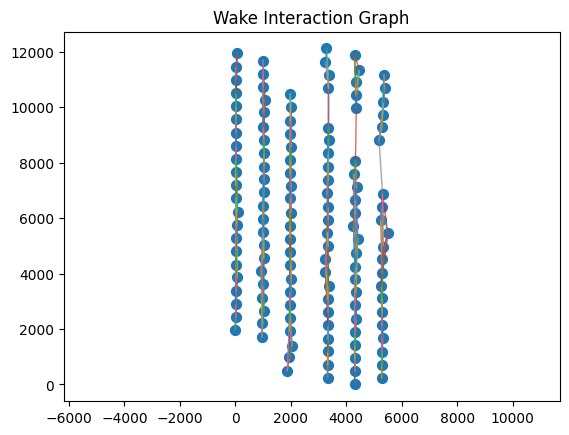

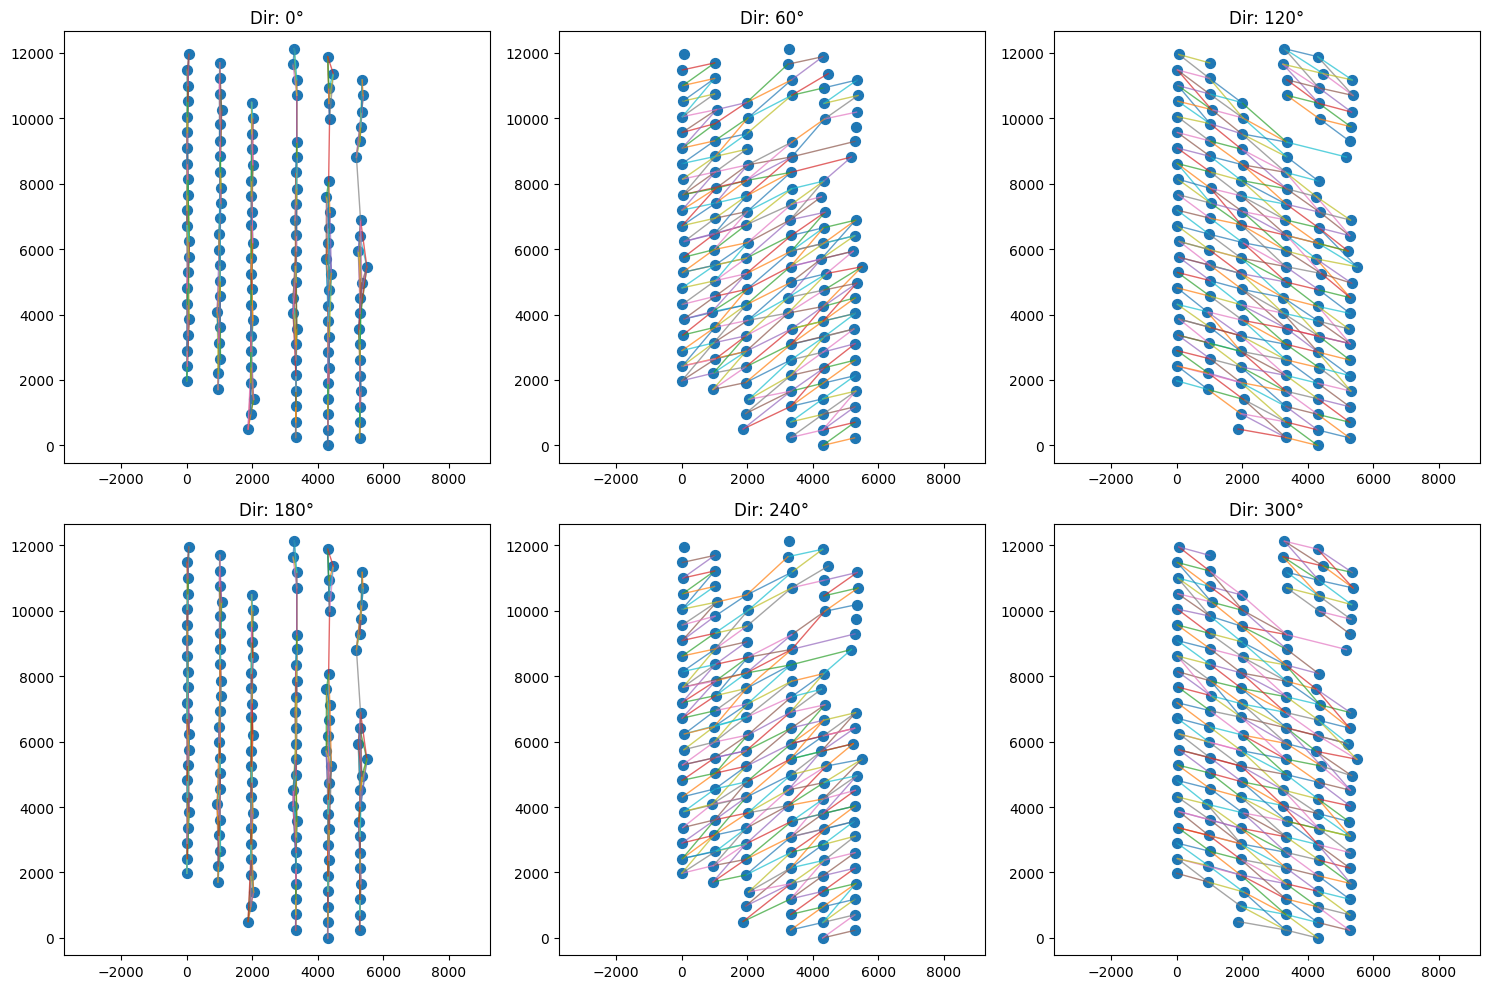

Edges for direction 0:
Edge from node 0 to node 20
Edge from node 0 to node 21
Edge from node 0 to node 22
Edge from node 0 to node 23
Edge from node 1 to node 0
Edge from node 1 to node 21
Edge from node 1 to node 22
Edge from node 1 to node 23
Edge from node 2 to node 0
Edge from node 2 to node 1
Edge from node 2 to node 22
Edge from node 2 to node 23
Edge from node 3 to node 0
Edge from node 3 to node 1
Edge from node 3 to node 2
Edge from node 3 to node 23
Edge from node 4 to node 0
Edge from node 4 to node 1
Edge from node 4 to node 2
Edge from node 4 to node 3
Edge from node 5 to node 1
Edge from node 5 to node 2
Edge from node 5 to node 3
Edge from node 5 to node 4
Edge from node 6 to node 2
Edge from node 6 to node 3
Edge from node 6 to node 4
Edge from node 6 to node 5
Edge from node 7 to node 3
Edge from node 7 to node 4
Edge from node 7 to node 5
Edge from node 7 to node 6
Edge from node 8 to node 6
Edge from node 8 to node 7
Edge from node 9 to node 7
Edge from node 9 to no

In [8]:
# Auto-generated from wake_graph.ipynb for pipeline integration

# --- Imports ---
import torch
from torch_geometric.data import Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from config import SPATIAL_GRAPH_TYPE, SPATIAL_RADIUS, K_NEIGHBORS, TEMPORAL_GRAPH_TYPE

# --- Wake Edge Computation ---
def compute_wake_edges(coords: np.ndarray,
                       wind_dir: float,
                       decay_length: float = 1000.0,
                       angle_threshold: float = 20.0,
                       max_distance: float = 1500.0) -> (np.ndarray, np.ndarray):
    """
    Determine wake interactions based on turbine locations and wind direction.

    Args:
        coords (np.ndarray): Array of shape (N, 2) with turbine x/y coordinates.
        wind_dir (float): Wind "from" direction in degrees.
        decay_length (float): Decay length for distance attenuation.
        angle_threshold (float): Angular half-width of the wake cone in degrees.
        max_distance (float): Maximum distance for establishing an edge.

    Returns:
        edge_index (np.ndarray): Array of shape (2, E) with source and target indices.
        edge_weights (np.ndarray): Array of shape (E,) with wake weights.
    """
    N = coords.shape[0]
    flow_dir = (wind_dir + 180.0) % 360.0  # Wind flow direction
    rows, cols, weights = [], [], []

    for i in range(N):
        xi, yi = coords[i]
        for j in range(N):
            if i == j:
                continue
            xj, yj = coords[j]
            dx, dy = xj - xi, yj - yi
            d = np.hypot(dx, dy)
            if d > max_distance or d == 0:
                continue

            # Bearing from i -> j in compass degrees
            ang_rad = np.arctan2(dy, dx)
            ang_deg = np.degrees(ang_rad)
            compass_ij = (90.0 - ang_deg) % 360.0

            # Angular difference
            diff = abs((compass_ij - flow_dir + 180.0) % 360.0 - 180.0)
            if diff <= angle_threshold:
                w = np.cos(np.radians(diff)) * np.exp(-d / decay_length)
                if w > 0:
                    rows.append(i)
                    cols.append(j)
                    weights.append(w)

    if rows:
        edge_index = np.vstack((np.array(rows), np.array(cols)))
        edge_weights = np.array(weights)
    else:
        edge_index = np.zeros((2, 0), dtype=int)
        edge_weights = np.array([])

    return edge_index, edge_weights

# --- Graph Generation ---
def build_wake_graph(coords: np.ndarray,
                     wind_dir: float,
                     include_weights: bool = True,
                     decay_length: float = 1000.0,
                     angle_threshold: float = 20.0,
                     max_distance: float = 1500.0) -> Data:
    """
    Build a PyG graph for a single wind direction.
    """
    edge_index, edge_weights = compute_wake_edges(coords, wind_dir,
                                                  decay_length, angle_threshold,
                                                  max_distance)
    edge_index_t = torch.tensor(edge_index, dtype=torch.long)
    edge_attr = torch.tensor(edge_weights, dtype=torch.float) if include_weights and edge_weights.size else None
    x = torch.tensor(coords, dtype=torch.float)
    return Data(x=x, edge_index=edge_index_t, edge_attr=edge_attr)


def build_wake_graphs(coords: np.ndarray,
                      wind_directions: list,
                      include_weights: bool = True,
                      **wake_kwargs) -> dict:
    """
    Generate wake graphs for multiple wind directions.

    Args:
        coords (np.ndarray): Array of turbine coordinates.
        wind_directions (list): List of wind "from" directions (degrees).
        include_weights (bool): Whether to include edge weights.
        **wake_kwargs: Additional args for compute_wake_edges.

    Returns:
        dict: Mapping from direction to PyG Data graphs.
    """
    graphs = {}
    for wd in wind_directions:
        graphs[wd] = build_wake_graph(coords, wd,
                                      include_weights,
                                      **wake_kwargs)
    return graphs

# --- Visualization ---

def plot_wake_graph(graph: Data, show: bool = True) -> None:
    """
    Plot the spatial wake graph structure for a single direction.
    """
    coords = graph.x.numpy()
    edge_index = graph.edge_index.numpy()
    weights = graph.edge_attr.numpy() if graph.edge_attr is not None else None

    plt.figure()
    plt.scatter(coords[:, 0], coords[:, 1], s=50)
    for idx, (u, v) in enumerate(edge_index.T):
        lw = 1 + 3 * weights[idx] if weights is not None else 1
        plt.plot([coords[u, 0], coords[v, 0]],
                 [coords[u, 1], coords[v, 1]],
                 linewidth=lw,
                 alpha=0.7)
    plt.title('Wake Interaction Graph')
    plt.axis('equal')
    if show:
        plt.show()


def plot_wake_graphs(graphs: dict,
                      cols: int = 3,
                      show: bool = True) -> None:
    """
    Plot multiple wake graphs in a grid layout.

    Args:
        graphs (dict): Mapping from wind direction to Data graph.
        cols (int): Number of columns in the grid.
        show (bool): Whether to call plt.show().
    """
    directions = list(graphs.keys())
    n = len(directions)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = np.array(axes).reshape(-1)

    for i, wd in enumerate(directions):
        ax = axes[i]
        graph = graphs[wd]
        coords = graph.x.numpy()
        edge_index = graph.edge_index.numpy()
        weights = graph.edge_attr.numpy() if graph.edge_attr is not None else None

        ax.scatter(coords[:, 0], coords[:, 1], s=50)
        for idx, (u, v) in enumerate(edge_index.T):
            lw = 1 + 3 * weights[idx] if weights is not None else 1
            ax.plot([coords[u, 0], coords[v, 0]],
                    [coords[u, 1], coords[v, 1]],
                    linewidth=lw,
                    alpha=0.7)
        ax.set_title(f"Dir: {wd}°")
        ax.axis('equal')

    # Hide unused subplots
    for j in range(n, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    if show:
        plt.show()

# --- Example Usage ---
if __name__ == '__main__':
    df_loc = pd.read_csv('GML/data/turbine_location.csv')
    coords = df_loc[['x', 'y']].values
    directions = [0, 60, 120, 180, 240, 300]
    graphs = build_wake_graphs(coords,
                               directions,
                               include_weights=False,
                               decay_length=1000.0,
                               angle_threshold=20.0,
                               max_distance=2000.0)
    # Plot for a check
    plot_wake_graph(graphs[directions[0]])
    plot_wake_graphs(graphs, cols = 3)
    # Print edges for first direction
    e_idx = graphs[directions[0]].edge_index.numpy()
    e_wts = graphs[directions[0]].edge_attr.numpy() if graphs[directions[0]].edge_attr is not None else None
    print(f"Edges for direction {directions[0]}:")
    for i in range(e_idx.shape[1]):
        src, dst = e_idx[0, i], e_idx[1, i]
        w = e_wts[i] if e_wts is not None else None
        print(f"Edge from node {src} to node {dst}" + (f" with weight {w:.3f}" if w is not None else ""))


ValueError: expected hh:mm:ss format

TimeIndex
0      0.000000
1    344.951697
2    354.594466
3    355.203426
4    354.480851
Name: FarmDomAbsDir, dtype: float64

Windows (size=10): WindowIndex
0      1.895104
1    334.966729
2    334.621859
3    315.189118
4    315.406474
Name: FarmDomAbsDir, dtype: float64
Window 500 DomAbsDir: 195.21°


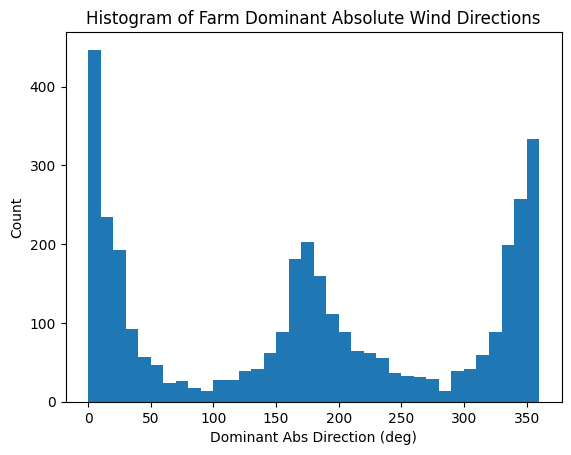

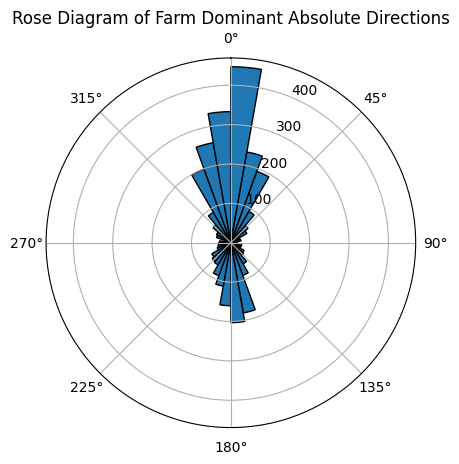

In [17]:
import pandas as pd
import numpy as np
from data_preprocessing import load_sdwpf_data  # Provides preprocessing and loading of SDWPF data fileciteturn4file0
# --- USER CONFIGURATION ---
# paths to your data
WIND_CSV        = "GML/data/wind_power_sdwpf.csv"         # CSV of wind directions; index=timestamp, columns=turbine IDs
POS_CSV         = "GML/data/turbine_location.csv"        # turbine positions, if needed
OUTPUT_TIMESTAMP = 4                                       # which window index to inspect
WINDOW_SIZE     = 10                                      # timestamps per batch (for grouping)
BIN_COUNT       = 36                                      # number of directional bins (e.g., 10° each)

# Auto-generated module to compute dominant wind directions via binned histogram + circular mean


# --- Helper Functions ---
def normalize_angle(angle_deg: np.ndarray) -> np.ndarray:
    """Normalize angles to [0, 360)."""
    return angle_deg % 360


def circular_mean_deg(angles_deg: np.ndarray) -> float:
    """Compute circular mean of angles in degrees."""
    radians = np.deg2rad(angles_deg)
    sin_sum = np.sum(np.sin(radians))
    cos_sum = np.sum(np.cos(radians))
    mean_rad = np.arctan2(sin_sum, cos_sum)
    return float(np.rad2deg(mean_rad) % 360)

# --- Absolute Wind Direction ---
def compute_absolute_wind_direction(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate absolute wind direction in degrees relative to true north (0-360°).
    Uses nacelle direction (Ndir) and sensor wind direction (Wdir).
    """
    df = df.copy()
    df['Wdir'] = df['Wdir'].fillna(0)
    df['Ndir'] = df['Ndir'].fillna(0)
    df['AbsWdir'] = normalize_angle(df['Ndir'] + df['Wdir'])
    return df

# --- Dominant Direction Computation ---
def dominant_direction(angles: np.ndarray, bins: int = BIN_COUNT) -> float:
    """
    Bin angles into equal-width bins, find the bin with highest count,
    and return the circular mean of angles in that bin.
    """
    dirs = normalize_angle(angles[~np.isnan(angles)])
    if dirs.size == 0:
        return np.nan
    counts, edges = np.histogram(dirs, bins=bins, range=(0, 360))
    idx = np.argmax(counts)
    low, high = edges[idx], edges[idx+1]
    spike = dirs[(dirs >= low) & (dirs < high)]
    return circular_mean_deg(spike) if spike.size > 0 else circular_mean_deg(dirs)

# --- Main Computation ---

def compute_timestamp_dominant(window_size: int = None) -> pd.Series:
    """
    Compute farm-wide dominant absolute wind direction per timestamp or window.

    Args:
        window_size (int or None): None for per timestamp; int for fixed-window grouping.
    Returns:
        pd.Series: Index = TimeIndex or WindowIndex; values = dominant abs wind direction (deg).
    """
    # Load raw data
    df = load_sdwpf_data(WIND_CSV)
    # Compute absolute wind direction
    df = compute_absolute_wind_direction(df)

    # Pivot by TimeIndex, Turbine ID
    wdir_df = df.pivot(index='TimeIndex', columns='TurbID', values='AbsWdir')

    if window_size is None:
        series = wdir_df.apply(lambda row: dominant_direction(row.values), axis=1)
        series.index.name = 'TimeIndex'
    else:
        grp = wdir_df.groupby(np.arange(len(wdir_df)) // window_size)
        series = grp.apply(lambda dfw: dominant_direction(dfw.values.flatten()))
        series.index.name = 'WindowIndex'

    series.name = 'FarmDomAbsDir'
    return series


def get_dominant_for_window(window_index: int,
                             window_size: int = WINDOW_SIZE) -> float:
    """
    Retrieve dominant absolute wind direction for a specific window.
    """
    series = compute_timestamp_dominant(window_size=window_size)
    try:
        return float(series.loc[window_index])
    except KeyError:
        raise IndexError(f"Window index {window_index} not found. Valid: 0 to {len(series)-1}")

# --- Visualization ---

def plot_dominant_histogram(series: pd.Series,
                            bins: int = BIN_COUNT,
                            show: bool = True) -> None:
    """
    Plot a standard histogram of dominant absolute directions.
    """
    plt.figure()
    plt.hist(series.dropna(), bins=bins, range=(0, 360))
    plt.xlabel('Dominant Abs Direction (deg)')
    plt.ylabel('Count')
    plt.title('Histogram of Farm Dominant Absolute Wind Directions')
    if show:
        plt.show()


def plot_dominant_rose(series: pd.Series,
                       bins: int = BIN_COUNT,
                       show: bool = True) -> None:
    """
    Plot a circular rose diagram of dominant absolute directions.
    """
    angles = series.dropna().values
    theta = np.deg2rad(angles)
    counts, bin_edges = np.histogram(theta, bins=bins, range=(0, 2*np.pi))
    widths = np.diff(bin_edges)
    ax = plt.subplot(projection='polar')
    ax.bar(bin_edges[:-1], counts, width=widths, edgecolor='black', align='edge')
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_title('Rose Diagram of Farm Dominant Absolute Directions')
    if show:
        plt.show()

# --- Example Usage ---
if __name__ == '__main__':
    # Per timestamp
    ts_dom = compute_timestamp_dominant()
    print(ts_dom.head())

    # Per window
    win_dom = compute_timestamp_dominant(window_size=WINDOW_SIZE)
    print(f"\nWindows (size={WINDOW_SIZE}):", win_dom.head())

    # Query specific window
    idx = 500
    try:
        print(f"Window {idx} DomAbsDir: {get_dominant_for_window(idx):.2f}°")
    except IndexError as e:
        print(e)

    # Plots
    plot_dominant_histogram(win_dom)
    plot_dominant_rose(win_dom)

